# Automatic PKIKP Onset Phase Picker

This notebook demonstrates the training and application of an automatic PKIKP onset phase picker. The google colab version is adopted from the orignal github repository developed by Jiarun Zhou (ANU)

* Zhou J., T.-S. Phạm, H. Tkalčić, Deep-learning phase-onset picker for deep Earth seismology: PKIKP waves, Journal of Geophysical Research: Solid Earth, 129 (9), doi:10.1029/2024JB029360, 2024.

* Original github repository: `https://github.com/JiarunZhou/PKIKP_Onset_Picker.git`

## Installing esstial package

In [1]:
!pip install obspy

## Model training

### Training datasets

First, load the training dataset of synthetic waveforms, which has three subsets: regular (synthetic P waves), target (particular emergent P waves), and control set (real noise). The waveforms are sampled at 40 Hz and generated to 20-s long.

In [2]:
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/Noise.hdf5
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/RegularP.hdf5
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/TargetP.hdf5

!du -sh *.hdf5

--2025-03-12 09:51:04--  https://github.com/JiarunZhou/PKIKP_Onset_Picker/raw/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/Noise.hdf5
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/JiarunZhou/PKIKP_Onset_Picker/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/Noise.hdf5 [following]
--2025-03-12 09:51:04--  https://media.githubusercontent.com/media/JiarunZhou/PKIKP_Onset_Picker/51d719642f03a49ef5f950866d12a8c2973cca21/Training_data/Noise.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 315314096 (301M) [application/octet-stream]
Saving to: ‘Noise.hdf5’

Noise.

In [3]:
from pathlib import Path
import h5py
import numpy as np

## basic parameters
sampling_rate = 40
waveform_len = 20
loading_num = 100000

## Load waveforms and onset labels.
## The labels are float indicating p onset locations for synthetic p waves,
## and 0 for noise.
dpath = Path('.')

x = []
y = []
for file in dpath.glob('*.hdf5'):
    print (file)
    with h5py.File(file, "r") as f:
        data = np.array(f["data"])[:loading_num]
        t0 = np.array(f["t0"])[:loading_num]
    x.append(data)
    y.append(t0)
print("Number in total: %d"%sum([len(a) for a in x]))

RegularP.hdf5
Noise.hdf5
TargetP.hdf5
Number in total: 295275


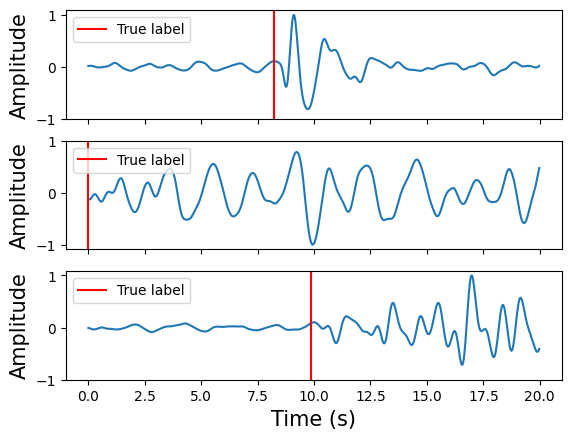

In [4]:
import matplotlib.pyplot as plt
# Plot an example from each subset
fig,ax = plt.subplots(nrows = 3, sharex = True)
for i in range(3):
    ax[i].plot(x[i][0])
    ax[i].axvline(y[i][0]*sampling_rate,c = "r",label = "True label")
    ax[i].set_ylabel("Amplitude", fontsize = 15)
    ax[i].set_yticks([-1,0,1])
    ax[i].legend(loc = "upper left")
ax[-1].set_xlabel("Time (s)", fontsize = 15)
ax[-1].set_xticks(np.arange(0,801,100),np.arange(0,21,2.5))
plt.show()

### Training

Build the network using TensorFlow.

In [5]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.losses import Huber, Reduction
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

def CNN_picker(npts, normalize = True, lr = 0.001):
    n_filters = [32, 64, 128, 256]
    s_kernels = [7, 5, 4, 3]

    # CNN
    inputs = Input(shape=(npts,1))
    x = inputs
    for n_filter, s_kernel in zip(n_filters, s_kernels):
        x = Conv1D(filters = n_filter, kernel_size = s_kernel, padding = 'same', activation = "relu")(x)
        x = MaxPooling1D()(x)
        if normalize:
            x = BatchNormalization()(x)
    x = Flatten()(x)

    # FCNN
    for _ in range(2):
        x = Dense(200, activation = 'relu')(x)
        if normalize:
            x = BatchNormalization()(x)

    outputs = Dense(1, activation = "linear")(x)
    model = Model(inputs = inputs, outputs = outputs)
    model.compile(loss=Huber(reduction = Reduction.SUM_OVER_BATCH_SIZE),
                  optimizer=Adam(learning_rate = lr))

    return model

model_raw = CNN_picker(npts = waveform_len*sampling_rate)
model_raw.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 800, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 800, 32)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 400, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 400, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 400, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 200, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 200, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 200, 128)            │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 100, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       2,560,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,746,137 (10.48 MB)

 Trainable params: 2,744,377 (10.47 MB)

 Non-trainable params: 1,760 (6.88 KB)

Train the model and plot the curves of loss during the training process. An early stopping method that allows training stops early if the validation loss has no longer decreased over 5 epochs is used.

Epoch 1/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - loss: 0.8692 - val_loss: 0.4618
Epoch 2/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 73s 9ms/step - loss: 0.4987 - val_loss: 0.3281
Epoch 3/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 77s 8ms/step - loss: 0.4673 - val_loss: 0.1526
Epoch 4/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.4561 - val_loss: 0.1021
Epoch 5/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.4524 - val_loss: 0.0812
Epoch 6/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.4498 - val_loss: 0.0719
Epoch 7/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 62s 8ms/step - loss: 0.4494 - val_loss: 0.1670
Epoch 8/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.4524 - val_loss: 0.0859
Epoch 9/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 0.4330 - val_loss: 0.0852
Epoch 10/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.4251 - val_loss: 0.1553
Epoch 11/20
7382/7382 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - loss: 0.4313 - val_loss: 0.0722
Epoch 12/20
7382/7

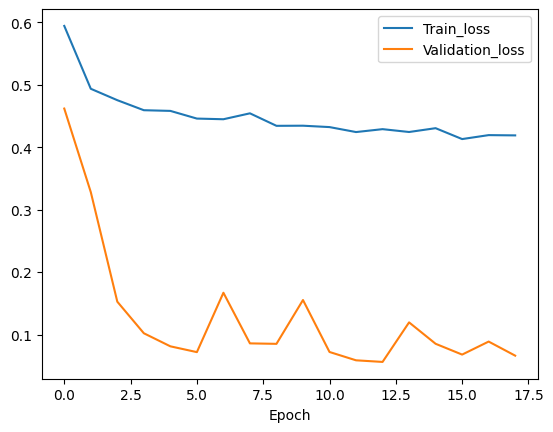

In [6]:
from time import time
from obspy.core import UTCDateTime

def trainer(x, y, model,
            epochs = 20,
            validation_split = 0.2,
            batch_size = 32,
            early_stop = True,
            verbose_training = 1,
            plot_hist = True, save_plot = "Loss_curve.jpg"):

    callbacks = []
    if early_stop == True:
        callbacks.append(
        EarlyStopping(monitor = 'val_loss',
                    start_from_epoch = 10,
                    patience = 5,
                    restore_best_weights = True,
                    verbose = 1)
        )

    start_training_time = time()
    hist = model.fit(x, y,
                    epochs = epochs,
                    validation_split = validation_split,
                    batch_size = batch_size,
                    callbacks = callbacks,
                    verbose = verbose_training)
    performance_time = time() - start_training_time

    print("Training starts at",UTCDateTime(start_training_time),"; costing:",performance_time)

    if plot_hist == True:
        #Loss curves
        train_loss = hist.history["loss"]
        val_loss = hist.history["val_loss"]
        plt.figure()
        plt.plot(range(len(train_loss)),train_loss, label = "Train_loss")
        plt.plot(range(len(val_loss)),val_loss, label = "Validation_loss")
        plt.xlabel("Epoch")
        plt.legend()
        if save_plot != False:
            plt.savefig(save_plot, dpi = 300)
        plt.show()

# Train
x = np.vstack(x)
y = np.vstack(y)

trainer(x, y,
        model_raw,
        epochs = 20,
        validation_split = 0.2,
        batch_size = 32,
        early_stop = True,
        verbose_training = 1,
        plot_hist = True, save_plot = "Loss_curve.jpg"
       )

## Onset picking test

In [ ]:
from Picker import *

### Picking

Here we load the trained model.

In [ ]:
!wget https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/TrainedModel.keras

--2025-03-12 05:59:31--  https://github.com/JiarunZhou/PKIKP_Onset_Picker/blob/main/TrainedModel.keras
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘TrainedModel.keras’

TrainedModel.keras      [ <=>                ] 221.41K  --.-KB/s    in 0.03s   

2025-03-12 05:59:31 (6.77 MB/s) - ‘TrainedModel.keras’ saved [226723]



In [ ]:
from tensorflow.keras.models import load_model

model = load_model('TrainedModel.keras')

ValueError: File not found: filepath=TrainedModel.keras. Please ensure the file is an accessible `.keras` zip file.

Read an observed real PKIKP waveform example. Here, the waveform has 150-s length. The predicted PKIKP onset by ak135 model (Kennett et al., 1995) is located at the 60th second. Hand-picked PKIKP absolute travel time is provided in its information.

In [ ]:
tr = read("Test_PKIKP/PKP_NE22.YP.BHZ.SAC")
PKIKP_travel_time = tr[0].stats.sac.t2
waveform_start = tr[0].stats.sac.b
onset = PKIKP_travel_time - waveform_start
prediction = 60

print("Wavefrom shape:",np.shape(tr))
print("PKIKP onset: ak135 prediction: %.2f s; Hand picking: %.2f s"%(prediction,onset))

Wavefrom shape: (1, 6001)
PKIKP onset: ak135 prediction: 60.00 s; Hand picking: 56.90 s


Pre-process the waveform. A default 50-s length waveform segment around the ak135 prediction is cut as the input of the automatic picker.

In [ ]:
sampling_rate = 40
len_input = 50
freq_filter = [0.5,2]
tr_cut = pre_process(tr, sampling_rate, len_input, freq_filter[0], freq_filter[1])

Pick the PKIKP onset on the processed waveform by calling the Picker function. A 20-s length window is shifting along the input waveform, and the network model returns an instantaneous pick for each step. The pick with the highest quality is chosen as the optimal one.

In [ ]:
auto_pick, quality = picker(tr_cut,model, sampling_rate, return_optimal = True)

print("Auto picked PKIKP onset: %.2f s picking quality: %.2f"%(auto_pick[0], quality[0]))
onset_in_window = onset - prediction + len_input / 2
print("Manual pick on the waveform: %.2f s"%onset_in_window)

Auto picked PKIKP onset: 21.66 s picking quality: 0.59
Manual pick on the waveform: 21.90 s


We can simply execute the Picker.py file to do the job above.

In [ ]:
!python Picker.py --data_list Test_PKIKP/List.txt --save_pick Test_PKIKP/Picks.txt --save_plot Test_PKIKP

Test_PKIKP/PKP_320.Z8.BHZ.SAC 
 Auto picked PKIKP onset: 24.66 s; Picking quality: 0.54
---------------
Test_PKIKP/PKP_DLV.RM.BHZ.SAC 
 Auto picked PKIKP onset: 26.79 s; Picking quality: 0.51
---------------
Test_PKIKP/PKP_NE22.YP.BHZ.SAC 
 Auto picked PKIKP onset: 21.66 s; Picking quality: 0.59
---------------


### Result plotting

We can acquire all picks with quality and get a quality plot.

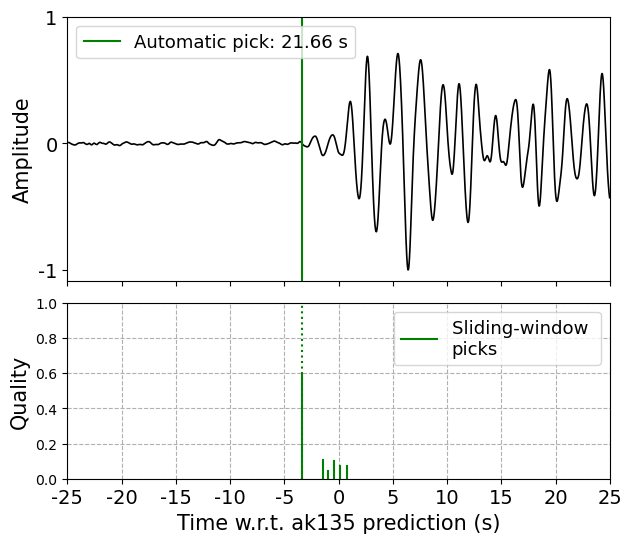

In [ ]:
auto_pick_plot(tr_cut, model, "Test_PKIKP/PKP_NE22.YP.BHZ.SAC.jpg")

An animation displaying the dynamic picking process is saved.

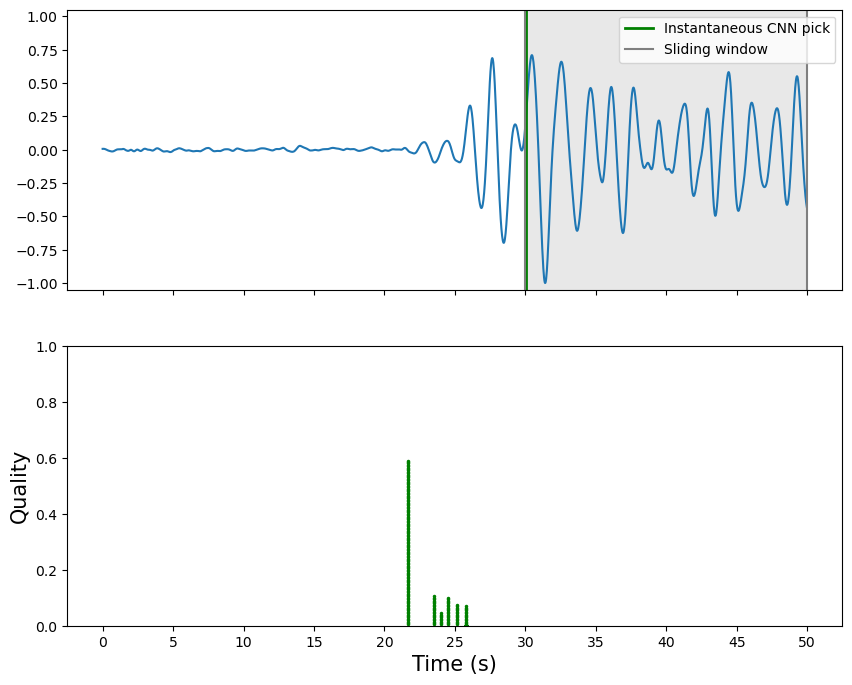

In [ ]:
picking_animation(tr_cut, model, save_name = "Test_PKIKP/Animation.mp4")